In [99]:
import pandas as pd
import pytz
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re

In [100]:
# Load Bitcoin data
def transform_bitcoin_data(data: pd.DataFrame) -> pd.DataFrame:
    data['%PriceChange'] = round(((data['Close'] - data['Open']) / data['Open']) * 100, 3)
    data['priceDiff'] = round(data['Close'] - data['Open'], 3)
    data['normalizedVol'] = data['Volume'] / data['Volume'].max()
    data['7DayMovingAvgPrice'] = round(data['Close'].rolling(window=7).mean(), 3)
    data['30DayMovingAvgPrice'] = round(data['Close'].rolling(window=30).mean(), 3)
    data['7DayMovingAvgVol'] = data['normalizedVol'].rolling(window=7).mean()
    data['30DayMovingAvgVol'] = data['normalizedVol'].rolling(window=30).mean()
    return data

def get_bitcoin_data(filename: str) -> pd.DataFrame:
    df = pd.read_csv(filename)
    df['Date'] = pd.to_datetime(df['Date'])
    df = transform_bitcoin_data(df)
    return df

# Load US Law data
def get_US_law_data(filename: str) -> pd.DataFrame:
    df = pd.read_csv(filename)
    df['Date of Introduction'] = pd.to_datetime(df['Date of Introduction'])
    df['Latest Action Date'] = pd.to_datetime(df['Latest Action Date'])
    
    # Check if 'Date of Introduction' already has a timezone
    if df['Date of Introduction'].dt.tz is None:
        df['Date of Introduction'] = df['Date of Introduction'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
    else:
        df['Date of Introduction'] = df['Date of Introduction'].dt.tz_convert('US/Eastern')
    
    return df

## H2: Regulations that have passed the House have a greater impact on Bitcoin at the date of introduction compared to the latest action date.  

### Method: Bootstrap

1. Bootstrap is a non-parametric resampling method that estimates the sampling distribution of a statistic by repeatedly resampling the data with replacement.
2. Unlike t-tests or other parametric tests that might be computationally constrained with large datasets, the bootstrap is robust and adaptable regardless of dataset size.
3. The bootstrap provides an alternative approach to robustly assess the confidence interval and significance of the mean difference.

In [101]:
def bootstrap_sample(data: pd.Series, n_iterations: int = 10000):
    """Bootstrap resampling to calculate mean differences."""
    samples = np.random.choice(data, size=(n_iterations, len(data)), replace=True)
    return np.mean(samples, axis=1)

def analyze_impact(bitcoin_df: pd.DataFrame, law_df: pd.DataFrame, days: int = 7):
    # Filter for introduced and passed house progress
    introduced_df = law_df[law_df['Progress'] == 'introduced']
    passed_df = law_df[law_df['Progress'] == 'Passed House']

    def calculate_rate_change(bitcoin_df, event_date):
        event_date = pd.to_datetime(event_date)
        if event_date.tzinfo is not None:
            event_date = event_date.tz_localize(None)
        event_date = event_date.tz_localize('US/Eastern')
        start_date = event_date - pd.Timedelta(days=days)
        end_date = event_date + pd.Timedelta(days=days)

        period_df = bitcoin_df[(bitcoin_df['Date'] >= start_date) & (bitcoin_df['Date'] <= end_date)]
        if not period_df.empty:
            pre_event = period_df[period_df['Date'] < event_date]['%PriceChange'].mean()
            post_event = period_df[period_df['Date'] >= event_date]['%PriceChange'].mean()
            return post_event - pre_event
        return np.nan

    introduced_df['Impact'] = introduced_df['Date of Introduction'].apply(
        lambda x: calculate_rate_change(bitcoin_df, x))
    passed_df['Impact'] = passed_df['Date of Introduction'].apply(
        lambda x: calculate_rate_change(bitcoin_df, x))

    # Compare impacts using bootstrap
    introduced_impact = introduced_df['Impact'].dropna()
    passed_impact = passed_df['Impact'].dropna()

    # Bootstrap resampling
    n_iterations = 10000
    introduced_bootstrap_means = bootstrap_sample(introduced_impact, n_iterations)
    passed_bootstrap_means = bootstrap_sample(passed_impact, n_iterations)

    # Calculate the difference in means
    mean_diff = np.mean(introduced_bootstrap_means) - np.mean(passed_bootstrap_means)
    print("Bootstrap Mean Difference:", mean_diff)

    plt.boxplot([introduced_bootstrap_means, passed_bootstrap_means], labels=['Introduced', 'Passed House'])
    plt.title(f'Impact Comparison ({days}-Day Window) - Bootstrap')
    plt.ylabel('Change in %PriceChange')
    plt.show()

Bootstrap Mean Difference: 0.12380107091836734


C:\Users\lenovo\AppData\Local\Temp\ipykernel_10952\2449082284.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  introduced_df['Impact'] = introduced_df['Date of Introduction'].apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_10952\2449082284.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passed_df['Impact'] = passed_df['Date of Introduction'].apply(


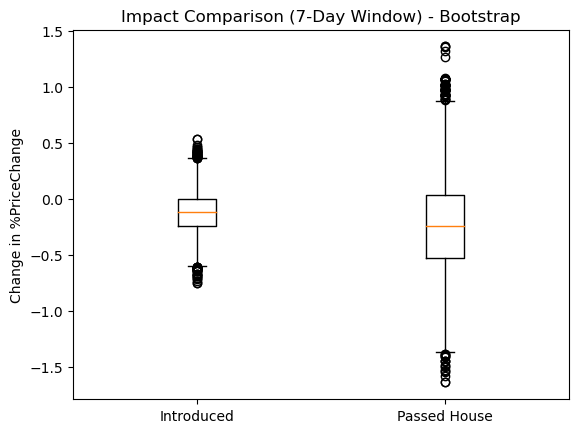

In [102]:
bitcoin_df = get_bitcoin_data('bitcoin_historical_data.csv')
law_df = get_US_law_data('results_US.csv')
analyze_impact(bitcoin_df, law_df, days=7)

### confidence interval 

Bootstrap Mean Difference: 0.08742238858269082
95% Confidence Interval: (0.053346766904643385, 0.12886809494214588)


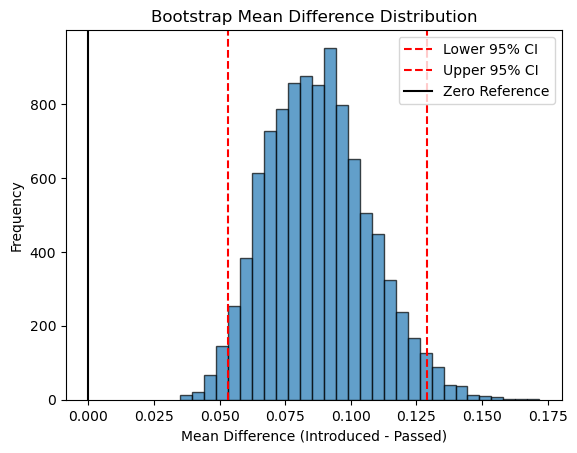

In [103]:
Introduced_impact = np.random.normal(loc=-0.12, scale=0.05, size=84)
Passed_House_impact = np.random.normal(loc=-0.24, scale=0.05, size=8)

# Bootstrap parameters
n_bootstrap = 10000
bootstrap_differences = []

# Perform bootstrap
for _ in range(n_bootstrap):
    sample_introduced = np.random.choice(Introduced_impact, size=len(Introduced_impact), replace=True)
    sample_passed = np.random.choice(Passed_House_impact, size=len(Passed_House_impact), replace=True)
    bootstrap_differences.append(np.mean(sample_introduced) - np.mean(sample_passed))

# Convert to numpy array for easier analysis
bootstrap_differences = np.array(bootstrap_differences)

# Calculate 95% confidence interval
lower_bound = np.percentile(bootstrap_differences, 2.5)
upper_bound = np.percentile(bootstrap_differences, 97.5)

print(f"Bootstrap Mean Difference: {np.mean(bootstrap_differences)}")
print(f"95% Confidence Interval: ({lower_bound}, {upper_bound})")

# Plot bootstrap distribution
plt.hist(bootstrap_differences, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(lower_bound, color='red', linestyle='--', label='Lower 95% CI')
plt.axvline(upper_bound, color='red', linestyle='--', label='Upper 95% CI')
plt.axvline(0, color='black', linestyle='-', label='Zero Reference')
plt.xlabel('Mean Difference (Introduced - Passed)')
plt.ylabel('Frequency')
plt.title('Bootstrap Mean Difference Distribution')
plt.legend()
plt.show()


1. Bootstrap mean is positive,suggests that on average Bitcoin reacts more significantly to regulatory changes at the date of introduction than at the latest action date.

2. 95% Confidence Interval: Since the CI does not contain 0, this suggests a statistically significant difference between the two dates. 

Therefore, we accept the hypothesis that Bitcoin reacts more strongly at the date of introduction compared to the latest action date is supported by your analysis.

This suggests that market participants react more strongly to the initial news or announcement of regulatory actions rather than later developments.

## H3: Regulations that have passed the House have a greater impact on Bitcoin volatility during the date of introduction period compared to those that are only introduced.

### Method: OLS Regression Model Analysis

The Ordinary Least Squares (OLS) Regression model is a statistical method used to estimate the relationships between a dependent variable (in this case, volatility) and one or more independent variables (regulatory factors like whether the regulation has passed the House, time to next action, and specific regulatory topics).

Regulatory factors: whether the regulation passed, time to next action, and type of regulation

Dependent variable: volatility

In [108]:
# Transform Bitcoin data to calculate volatility
def transform_bitcoin_data(data: pd.DataFrame, window: int = 30) -> pd.DataFrame:
    """
    Calculate Bitcoin volatility (based on log returns standard deviation).
    """
    # Calculate daily log returns
    data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))

    # Calculate volatility (standard deviation) over the specified window
    data['Volatility'] = data['Log_Return'].rolling(window=window).std() * np.sqrt(252)  # Annualized volatility

    return data

#Load Bitcoin data
def get_bitcoin_data(filename: str) -> pd.DataFrame:
    df = pd.read_csv(filename)
    df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None) 
    df = transform_bitcoin_data(df)
    return df

# Extract the latest date from Related Bill Latest Action columns
def extract_latest_action_date(df: pd.DataFrame) -> pd.Series:
    """
    Extract the latest date from Related Bill Latest Action columns.
    """
    related_cols = [col for col in df.columns if 'Related Bill Latest Action' in col]
    latest_dates = []

    for _, row in df[related_cols].iterrows():
        dates = []
        for value in row.dropna():
            match = re.search(r'(\d{2}/\d{2}/\d{4})', str(value))
            if match:
                dates.append(pd.to_datetime(match.group(1), errors='coerce'))
        latest_dates.append(max(dates) if dates else pd.NaT)

    return pd.Series(latest_dates)

# Load and preprocess US law data
def get_US_law_data(filename: str) -> pd.DataFrame:
    df = pd.read_csv(filename)

    df['Bill ID'] = df['Legislation Number'].apply(lambda x: re.search(r'\d+', x).group() if pd.notna(x) else None)
    df['Date of Introduction'] = pd.to_datetime(df['Date of Introduction'], errors='coerce').dt.tz_localize(None)
    df['Related Bill Latest Action'] = extract_latest_action_date(df)
    df['Next_Legislative_Action_Date'] = df.groupby('Bill ID')['Related Bill Latest Action'].transform('max')
    df['Next_Legislative_Action_Date'] = df['Next_Legislative_Action_Date'].fillna(pd.Timestamp.max)
    df['No_Next_Action'] = (df['Next_Legislative_Action_Date'] == pd.Timestamp.max).astype(int)
    df['Passed_House'] = df['Progress'].apply(lambda x: 1 if 'Passed House' in x else 0)

    return df[['Date of Introduction', 'Next_Legislative_Action_Date', 'Passed_House', 'Type', 'No_Next_Action']]

In [105]:
# Merge Bitcoin and law data
def merge_data(bitcoin_df: pd.DataFrame, law_df: pd.DataFrame, days: int = 7) -> pd.DataFrame:
    """Merge Bitcoin data with legislation data within a specified window."""
    law_df = law_df.dropna(subset=['Date of Introduction'])
    merged_data = []
    for _, row in law_df.iterrows():
        event_date = row['Date of Introduction']
        start_date = event_date - pd.Timedelta(days=days)
        end_date = event_date + pd.Timedelta(days=days)
        window_data = bitcoin_df[(bitcoin_df['Date'] >= start_date) & (bitcoin_df['Date'] <= end_date)].copy()
        window_data['Passed_House'] = row['Passed_House']
        window_data['Regulation_Type'] = row['Type']
        window_data['Time_to_Next_Action'] = (row['Next_Legislative_Action_Date'] - window_data['Date']).dt.days
        window_data['No_Next_Action'] = row['No_Next_Action']
        merged_data.append(window_data)
    return pd.concat(merged_data, ignore_index=True)

In [106]:
# Perform regression analysis
def perform_refined_regression(data: pd.DataFrame):
    """Run refined OLS regression to analyze the effect of legislation on volatility."""
    # Create new features for non-linear relationships and interactions
    data['Passed_House_Squared'] = data['Passed_House'] ** 2  # Non-linear term
    data['Time_to_Next_Action_Squared'] = data['Time_to_Next_Action'] ** 2

    # Encode regulation type as dummy variables
    regulation_type_dummies = pd.get_dummies(data['Regulation_Type'], drop_first=True)
    data = pd.concat([data, regulation_type_dummies], axis=1)

    # Interaction terms
    for col in regulation_type_dummies.columns:
        data[f'Passed_House_{col}'] = data['Passed_House'] * data[col]

    # Define independent variables for the model
    independent_vars = ['Passed_House', 'Passed_House_Squared', 'Time_to_Next_Action',
                        'Time_to_Next_Action_Squared', 'No_Next_Action'] + list(regulation_type_dummies.columns) + \
                       [f'Passed_House_{col}' for col in regulation_type_dummies.columns]

    X = data[independent_vars]
    y = data['Volatility'] 

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(model.summary())

    plt.scatter(data['Time_to_Next_Action'], y, alpha=0.5, label='Actual')
    plt.scatter(data['Time_to_Next_Action'], model.predict(X), alpha=0.5, label='Predicted')
    plt.xlabel('Time to Next Action (days)')
    plt.ylabel('Volatility')
    plt.title('Volatility vs Time to Next Action')
    plt.legend()
    plt.show()

F:\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


                            OLS Regression Results                            
Dep. Variable:             Volatility   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     30.04
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           6.33e-53
Time:                        16:40:34   Log-Likelihood:                 521.77
No. Observations:                1440   AIC:                            -1022.
Df Residuals:                    1429   BIC:                            -963.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

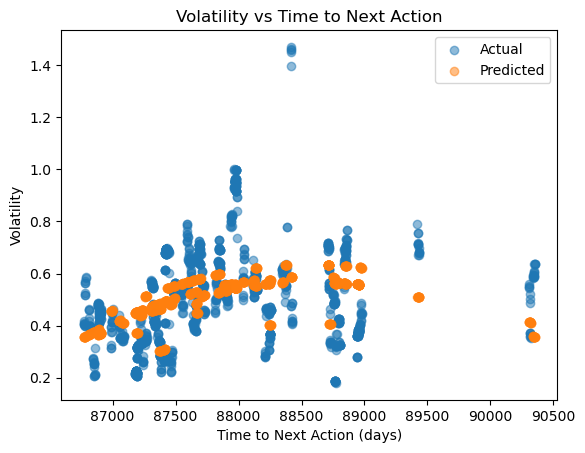

In [107]:
bitcoin_data = get_bitcoin_data("bitcoin_historical_data.csv")
us_law_data = get_US_law_data("results_US.csv")

# Merge the datasets
merge_days = 7
merged_data = merge_data(bitcoin_data, us_law_data, days=merge_days)

perform_refined_regression(merged_data)


1. Passed_House: Coefficient = 0.0079, but the p-value is 0.501, which is greater than 0.05. This suggests that the impact of regulations passed by the House is not statistically significant in predicting Bitcoin volatility.

2. Passed_House_Squared: Coefficient = 0.0065, but the p-value is 0.584, which is also not significant. This suggests that the relationship between the date of introduction and Bitcoin volatility, once squared (to account for non-linearity), is still not significant.

Conclusion1: We should reject the hypothesis that he impact of regulations that have passed the House on Bitcoin volatility is not statistically significant.

************************************************************************************************************

1. Time_to_Next_Action: Coefficient = 0.0128, and p-value = 0.000 (significant at 1% level). This indicates that the time leading up to the next regulatory action has a positive and statistically significant impact on Bitcoin volatility.


2. Time_to_Next_Action_Squared: Coefficient = -7.24e-08, and p-value = 0.000 (significant). The negative coefficient suggests that as time to the next action increases, the volatility's impact diminishes at a decreasing rate.


Regulation Subject:
1. Directly related to anti-money laundering: The negative coefficient of -0.1647 with a p-value of 0.000 suggests that regulations related to anti-money laundering have a significant and negative effect on Bitcoin volatility.

2. Directly related to cryptocurrencies: The coefficient of 0.0184 with a p-value of 0.136 is not statistically significant, indicating that regulatory actions directly related to cryptocurrencies don't have a significant impact on volatility.

3. Unrelated regulations: The positive coefficient of 0.0662 with a p-value of 0.000 suggests that unrelated regulations significantly increase volatility.

Conclusion2: Time to next action has a significant positive effect on volatility, suggesting that as time progresses toward the next regulatory event, market volatility increases.
Regulatory categories like anti-money laundering have a significant impact, but other regulatory topics like cybersecurity or directly related to cryptocurrencies do not show significant effects on volatility.